### Optimal control of the ALN model
This notebook shows how to compute the optimal control (OC) signal for the ALN model for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2


# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
# We import the model
model = ALNModel()
model.params.mue_ext_mean = 2. # up state
model.run()
setinitstate(model, getfinalstate(model))

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

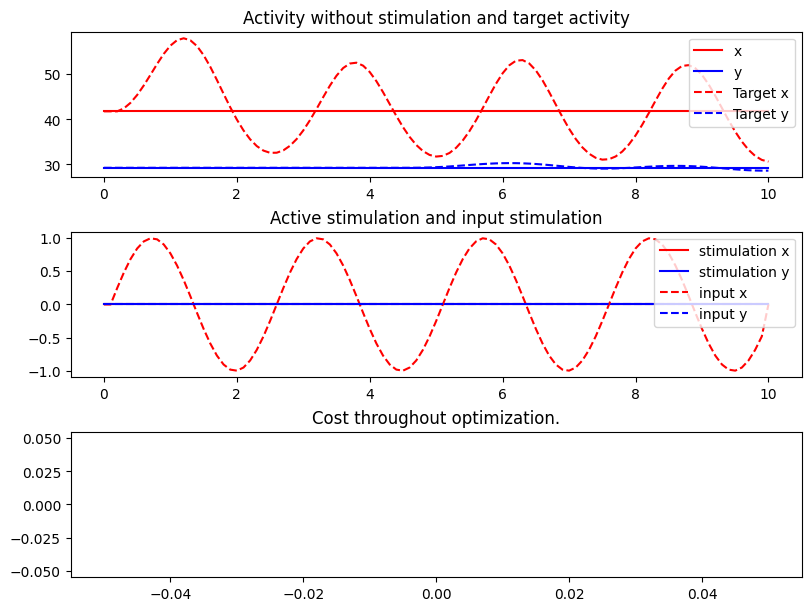

In [3]:
# We set the stimulus in x and y variables, and run the simulation
model.params["ext_exc_current"] = input
model.params["ext_inh_current"] = zero_input
model.run()

# Define the result of the stimulation as target
target = getstate(model)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input
model.params["ext_inh_current"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: 321.0439238667038
Cost in iteration 25: 0.443708199047311
Cost in iteration 50: 0.04539405430692951
Cost in iteration 75: 0.013586419991225592
Cost in iteration 100: 0.0059645591130940345
Cost in iteration 125: 0.003306028616424848
Cost in iteration 150: 0.002083251587845721
Cost in iteration 175: 0.0014090618723537872
Cost in iteration 200: 0.0010123982190292263
Cost in iteration 225: 0.0007519729883021353
Cost in iteration 250: 0.0005780140949643307
Cost in iteration 275: 0.0004535294336149246
Cost in iteration 300: 0.00036278389488091133
Cost in iteration 325: 0.0002959258592375127
Cost in iteration 350: 0.00024199313672603202
Cost in iteration 375: 0.00020129735453864185
Cost in iteration 400: 0.0001684086927751941
Cost in iteration 425: 0.00014215661048202387
Cost in iteration 450: 0.00012114569100043589
Cost in iteration 475: 0.00010322143188193938
Cost in iteration 500: 8.872918799046519e-05
Final cost : 8.872918799

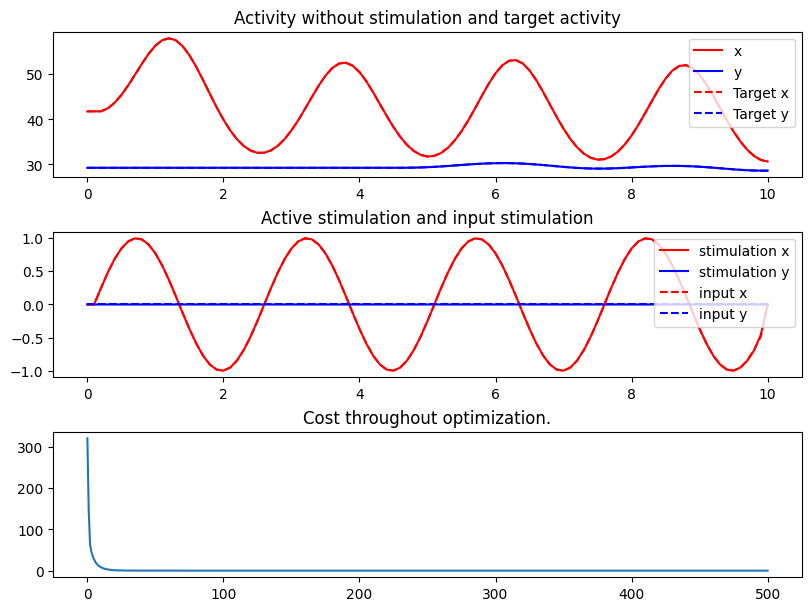

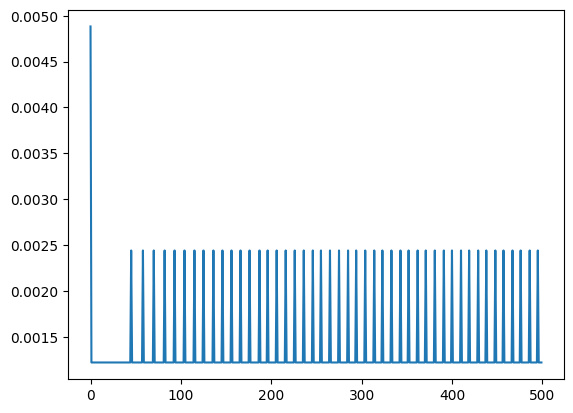

In [4]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25))
model_controlled.weights["w_p"] = 1. # default value 1
model_controlled.weights["w_2"] = 0. # default value 0

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()

Compute control for a deterministic system
Cost in iteration 0: 8.872918799046519e-05
Cost in iteration 25: 7.688046845458508e-05
Cost in iteration 50: 6.630975010027184e-05
Cost in iteration 75: 5.774237655997777e-05
Cost in iteration 100: 5.034221068524504e-05
Final cost : 5.034221068524504e-05


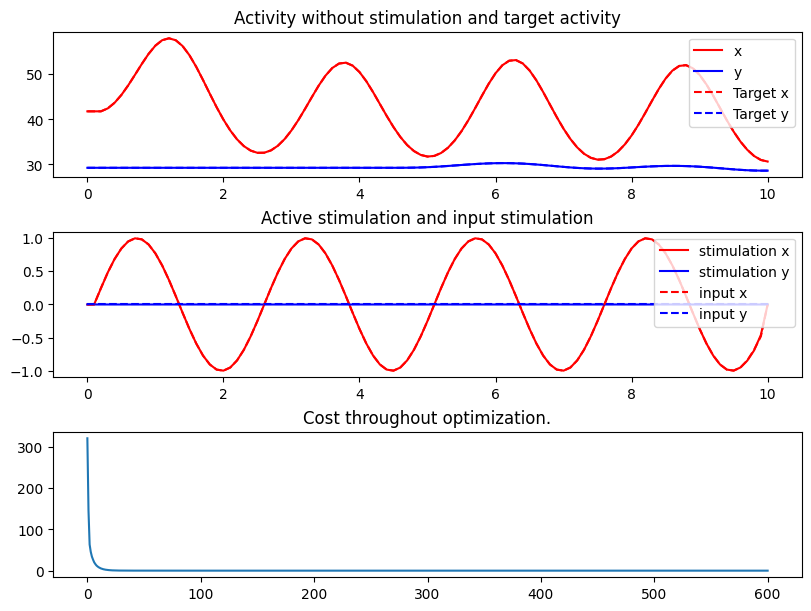

In [5]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of model oscillators. We first define the coupling matrix and the distance matrix. We can then initialize the model.

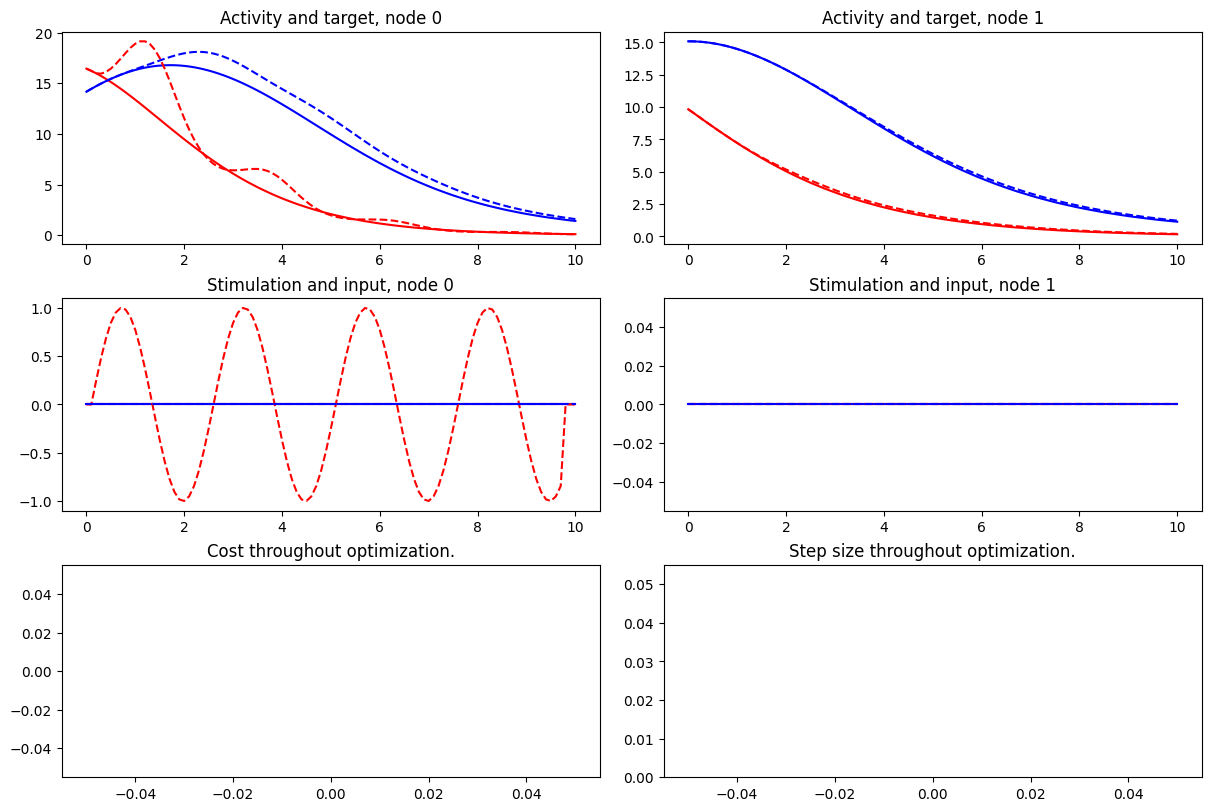

In [6]:
cmat = np.array( [[0., 0.5], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = ALNModel(Cmat=cmat, Dmat=dmat)
model.params.de = 0.0
model.params.di = 0.0
model.run()
setinitstate(model, getfinalstate(model))

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.3, dt)/period) # other functions or random values can be used as well

# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.06465641330615582
Cost in iteration 25: 0.000495718577084971
Cost in iteration 50: 0.0003891993874471005
Cost in iteration 75: 0.00032425324939917697
Cost in iteration 100: 0.00028244764528749896
Cost in iteration 125: 0.0002517483609501449
Cost in iteration 150: 0.00022970619486855764
Cost in iteration 175: 0.00021140136673608405
Cost in iteration 200: 0.00019539570774077246
Cost in iteration 225: 0.00018205827885066375
Cost in iteration 250: 0.0001701554706222619
Cost in iteration 275: 0.00015894707578580287
Cost in iteration 300: 0.00014995111240729073
Cost in iteration 325: 0.00014128704619748202
Cost in iteration 350: 0.00013341673576982267
Cost in iteration 375: 0.00012613975168123374
Cost in iteration 400: 0.00011950810445235624
Cost in iteration 425: 0.00011350412235698292
Cost in iteration 450: 0.00010783524316664295
Cost in iteration 475: 0.0001026204248458219
Cost in iteration 500: 9.780594913661765e-05
Final 

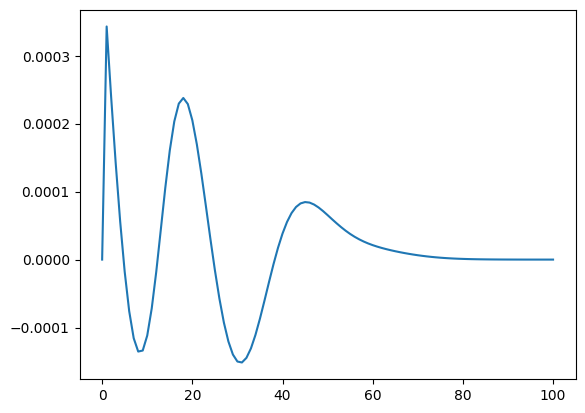

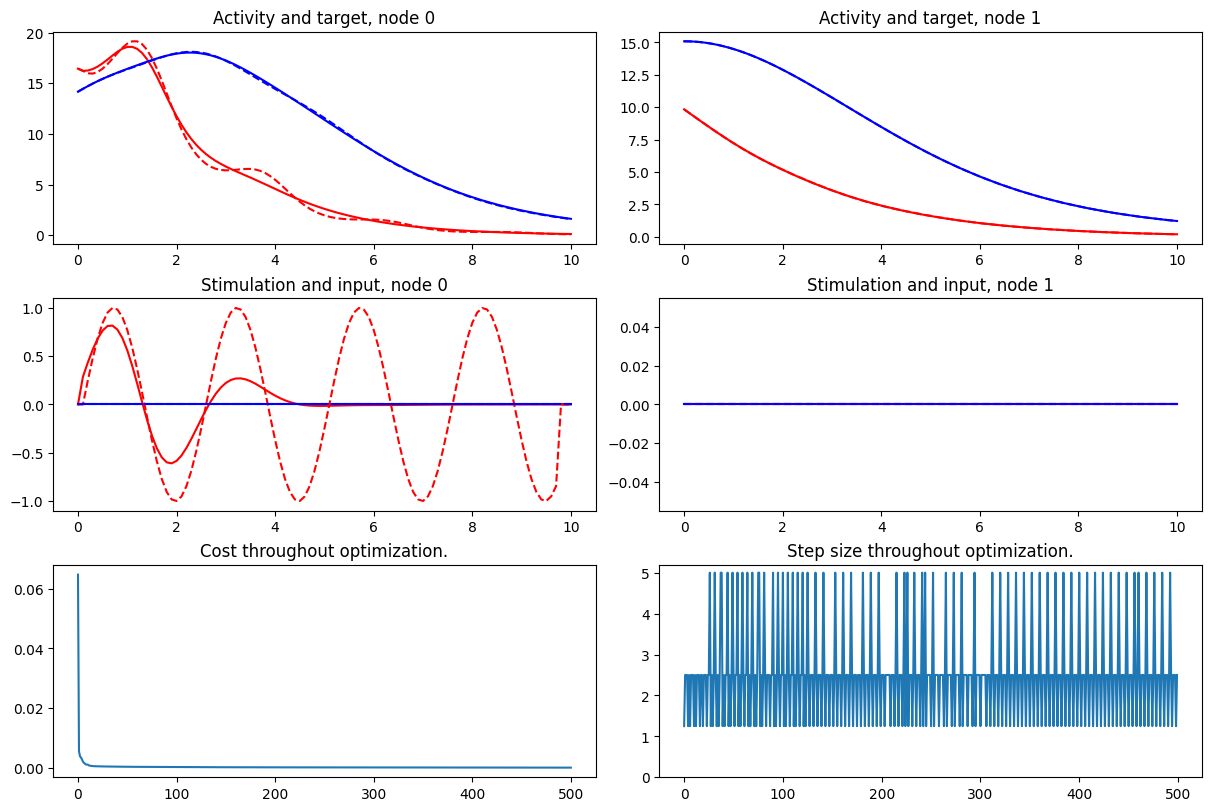

In [7]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[1,0] = 1. # only measure in y-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

plt.plot(model_controlled.gradient[0,0,:])
plt.show()

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 9.780594913661765e-05
Cost in iteration 100: 8.163589499823023e-05
Cost in iteration 200: 6.922076742493402e-05
Cost in iteration 300: 5.9520818293729495e-05
Cost in iteration 400: 5.173725795378379e-05
Cost in iteration 500: 4.554046897524321e-05
Cost in iteration 600: 4.062901662394422e-05
Cost in iteration 700: 3.659895734674069e-05
Cost in iteration 800: 3.3463123319166986e-05
Cost in iteration 900: 3.087466652429741e-05
Cost in iteration 1000: 2.8742531484044858e-05
Final cost : 2.8742531484044858e-05


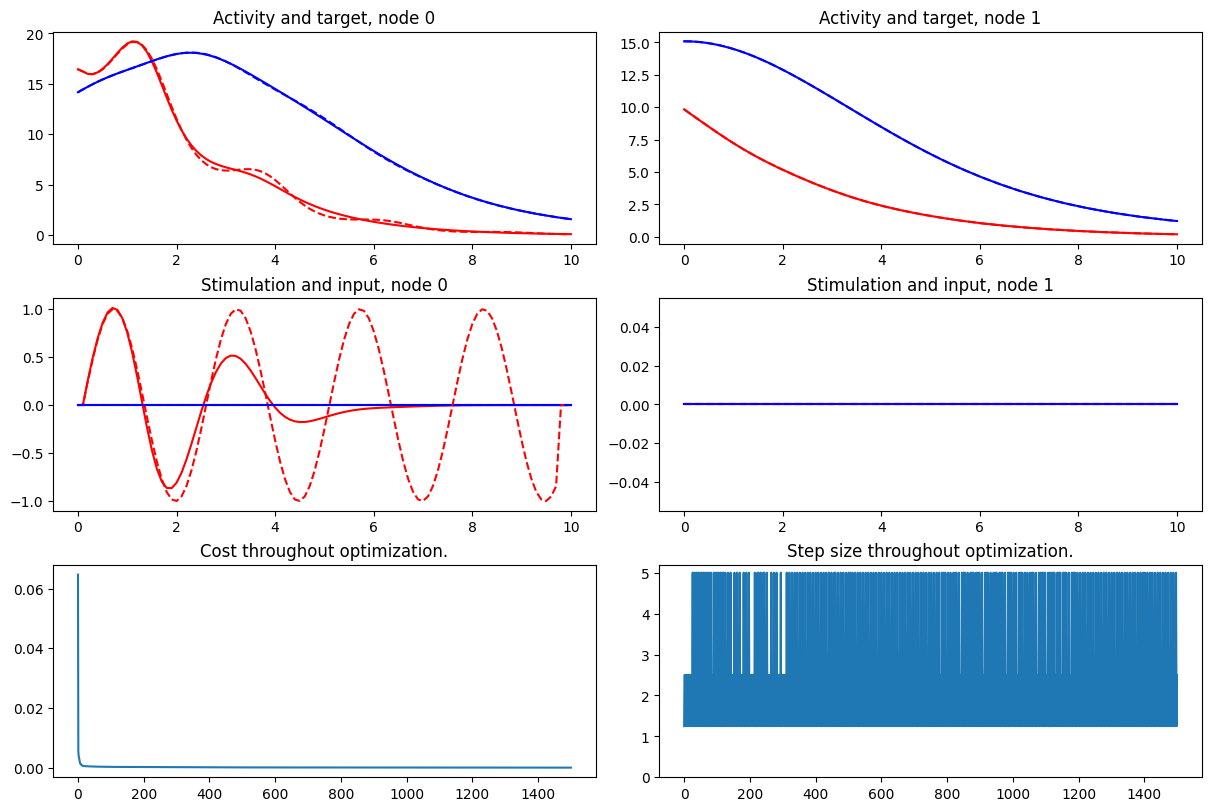

In [8]:
# Do another 1000 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.zero_step_encountered = False
model_controlled.print_array = np.arange(0,1001,100)
model_controlled.optimize(1000)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

### Delayed network of neural populations

We now consider a network topology with delayed signalling between the two nodes.

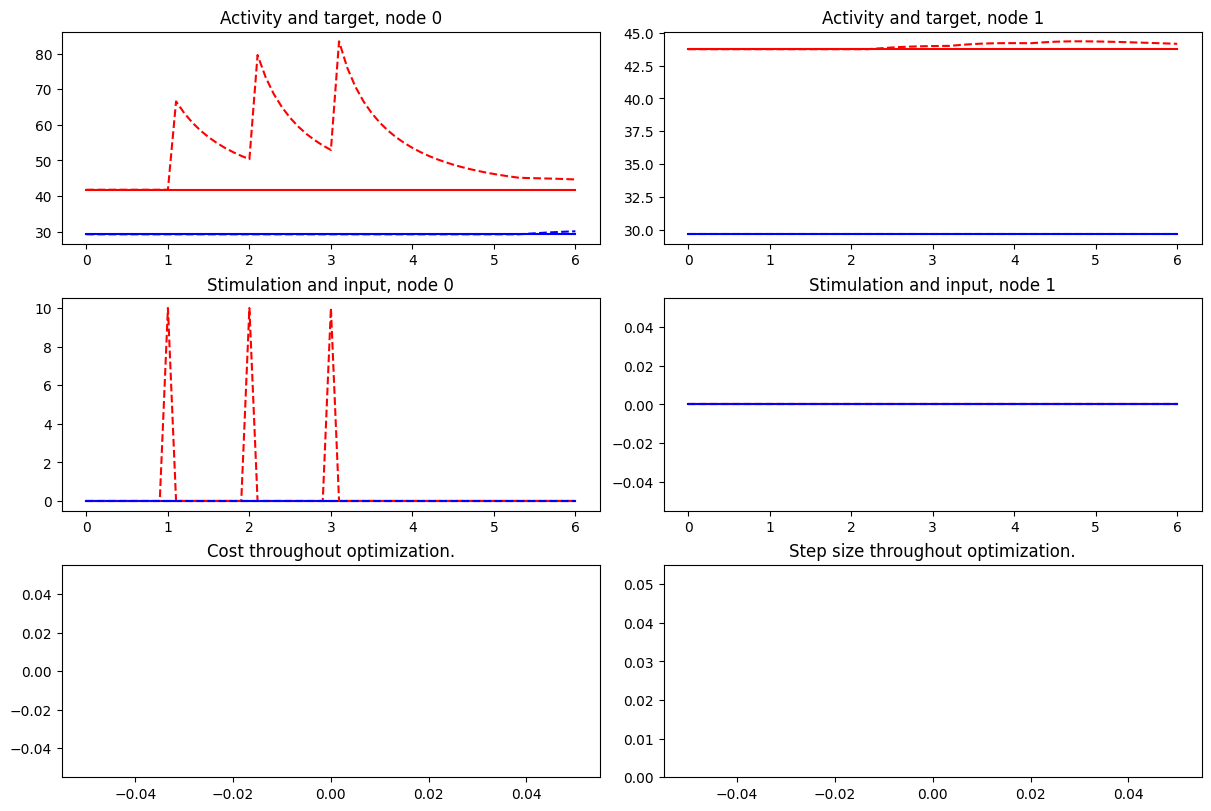

In [9]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [18, 0.]] ) # distance from 0 to 1, delay is computed by dividing by the signal speed params.signalV

model = ALNModel(Cmat=cmat, Dmat=dmat)

model.params.mue_ext_mean = 2. # up state
model.run()
setinitstate(model, getfinalstate(model))

duration = 6.
model.params.duration = duration
model.run()

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[0,10] = 10. 
input[0,20] = 10.
input[0,30] = 10. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.3677260138951115
Cost in iteration 25: 0.0009659517862440941
Cost in iteration 50: 0.0007383556229397968
Cost in iteration 75: 0.0006216606962821808
Cost in iteration 100: 0.0005423531340705725
Cost in iteration 125: 0.0004786851528752075
Cost in iteration 150: 0.00042808923208869693
Cost in iteration 175: 0.00038319452223245726
Cost in iteration 200: 0.000345754792881663
Cost in iteration 225: 0.00031381996885273346
Cost in iteration 250: 0.0002865349907287035
Cost in iteration 275: 0.0002632779637964881
Cost in iteration 300: 0.00024206720645092984
Cost in iteration 325: 0.00022326373163867133
Cost in iteration 350: 0.0002067438529290771
Cost in iteration 375: 0.0001924163642187274
Cost in iteration 400: 0.00017975283204063497
Cost in iteration 425: 0.00016778841365136822
Cost in iteration 450: 0.00015757765823303874
Cost in iteration 475: 0.00014863530346712113
Cost in iteration 500: 0.00014037128023133434
Final cost 

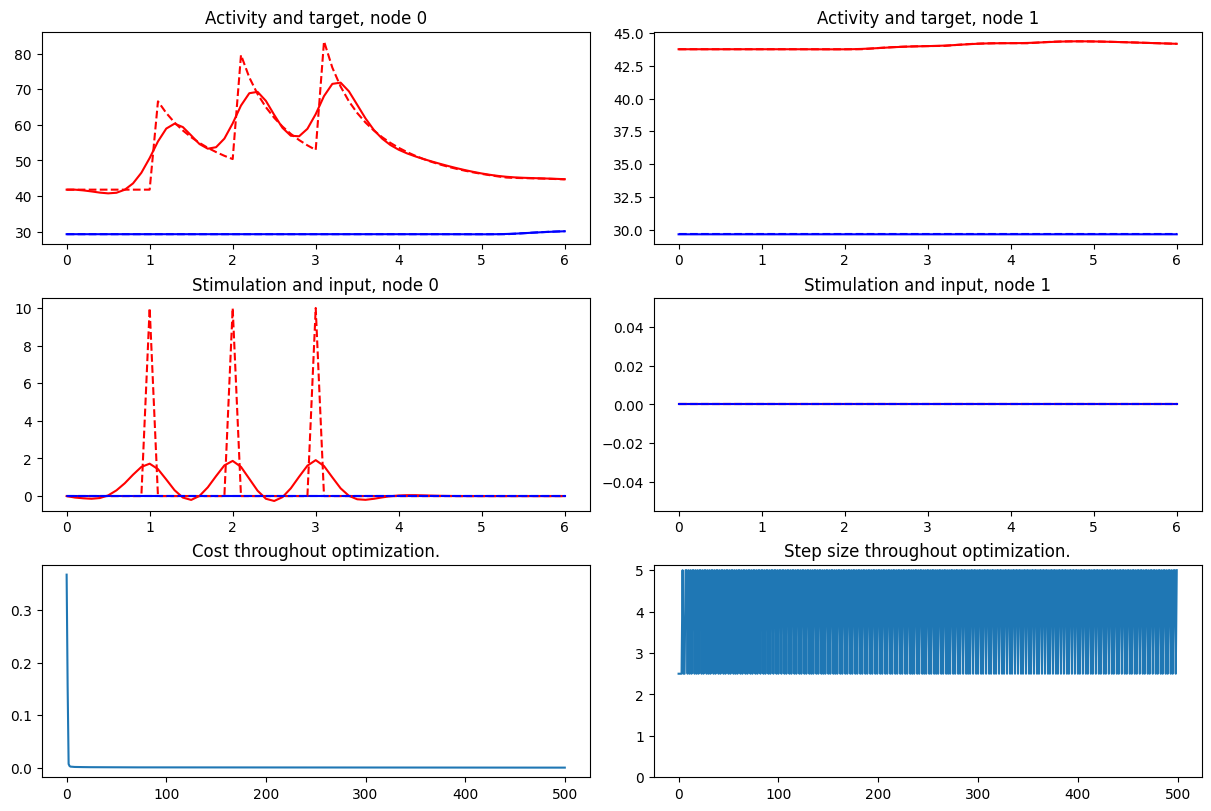

In [10]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 0.00014037128023133434
Cost in iteration 25: 0.0001331628139622585
Cost in iteration 50: 0.00012663434523352385
Cost in iteration 75: 0.00012061113213163003
Cost in iteration 100: 0.000114999931039876
Final cost : 0.000114999931039876


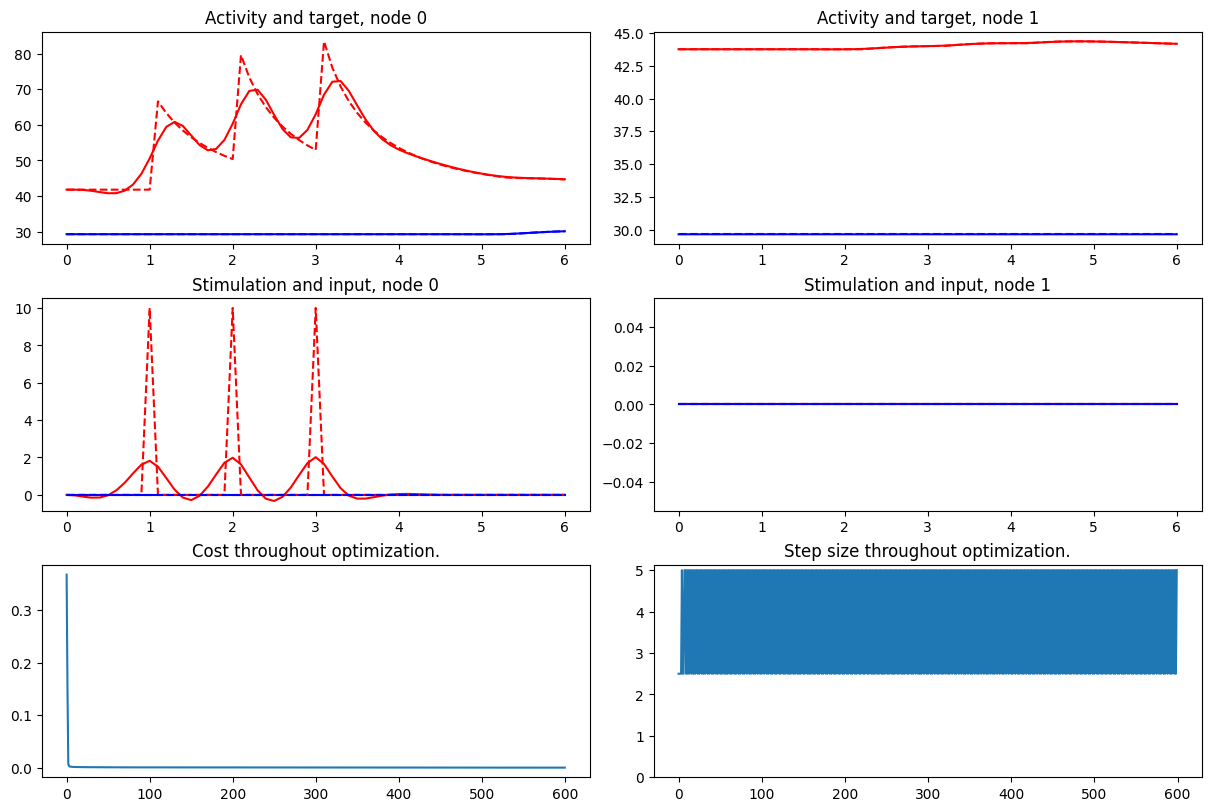

In [11]:
# perofrm another 100 iterations to improve result
# repeat execution to add another 100 iterations
# converence to the input stimulus is relatively slow for the WC nodel
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)